# Getting started with eartrack

In [1]:
%matplotlib notebook

import os
import numpy as np
import matplotlib.pyplot as plt

import openalea.eartrack
import openalea.eartrack.eartrack as et_lib
import openalea.eartrack.binarisation_folder as st_lib
from openalea.deploy.shared_data import shared_data

def img_show(imgs, titles):
    fig, axes = plt.subplots(nrows=int((len(imgs)-1)/3) + 1, ncols=min(3, len(imgs)))
    axlist = fig.get_axes()
    for i in range(len(imgs)):
        axlist[i].axis('off')
        axlist[i].set_title(titles[i])
        axlist[i].imshow(imgs[i])

NOT using graph editor observer No module named grapheditor


## Get example images and parameters needed for segmentation and ear tracking

In [2]:
# Read images' information and create output folders
share_data_directory = shared_data(openalea.eartrack)
param_folder = os.path.join(share_data_directory, "parameters")
images_folder = os.path.join(share_data_directory, "images")

img_desc, parameters = st_lib.init(param_folder, images_folder, "", log=False)

## Selection of one plant and one imaging task

In [3]:
plant = img_desc.keys()[0]
task = img_desc[plant].keys()[0]

cabin = img_desc[plant][task]['cabin']

## Read images and show them

<IPython.core.display.Javascript object>


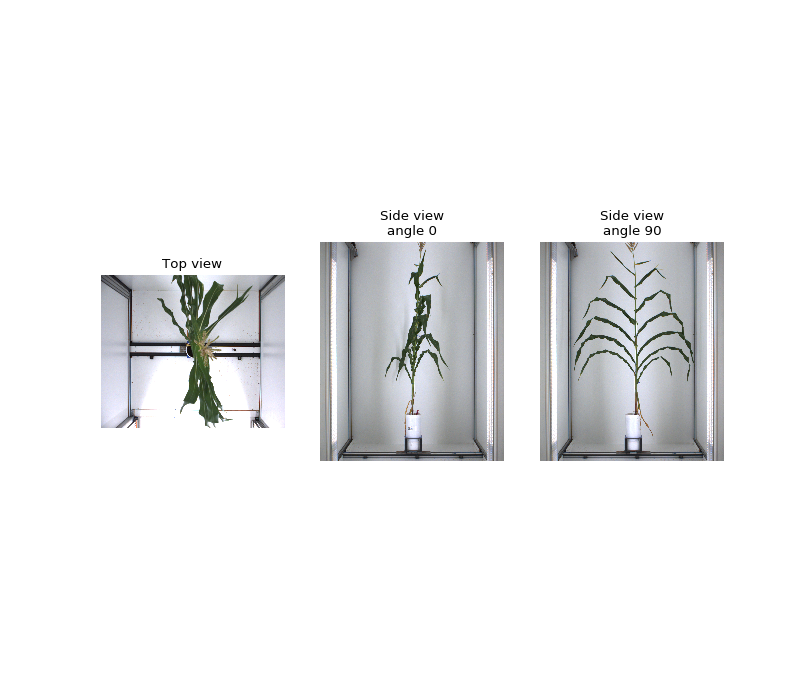

In [4]:
images = st_lib.read_images(img_desc, plant, task)

img_show([images["top"][0][:,:,::-1], images["side"][0][:,:,::-1], images["side"][90][:,:,::-1]], 
         ["Top view", "Side view\nangle 0", "Side view\nangle 90"])

## Compute binaries and show them

<IPython.core.display.Javascript object>


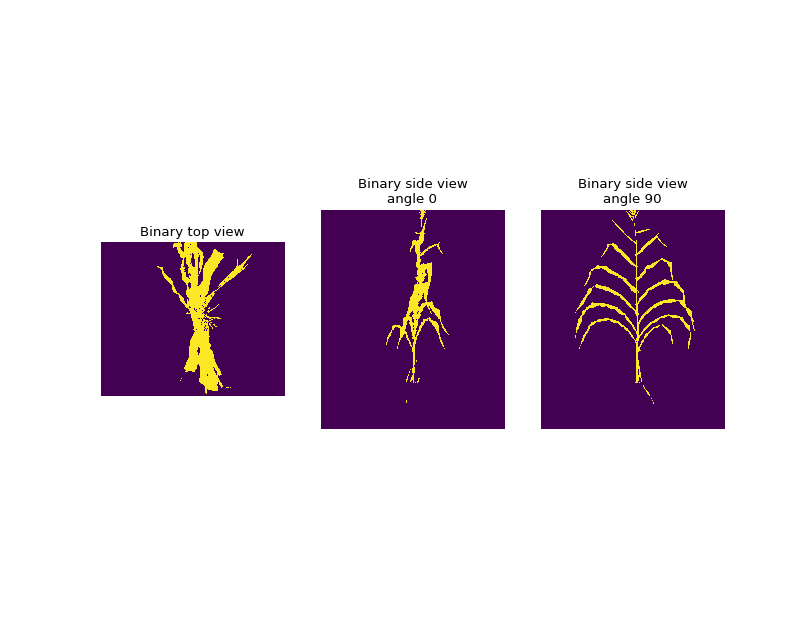

In [5]:
binaries, mask_top_center = st_lib.binaries_calculation(images, cabin, parameters)

img_show([binaries["top"][0], binaries["side"][0], binaries["side"][90]], 
         ["Binary top view", "Binary side view\nangle 0", "Binary side view\nangle 90"])

## Selection of best side view images based on top view image

<IPython.core.display.Javascript object>


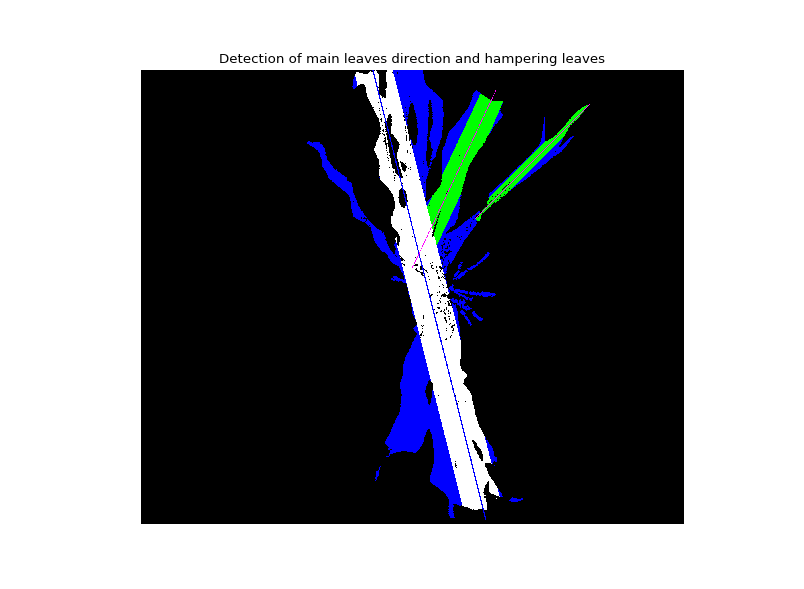

In [6]:
existing_angles = binaries["side"].keys()
angles_to_keep, result_img, top_log = et_lib.top_analysis(binaries["top"][0], existing_angles, mask_top_center)

img_show([result_img], ["Detection of main leaves direction and hampering leaves"])

## Find ear position in best side view images

In [7]:
kept_positions = np.empty([0, 3], 'int')
useful_kept_images = np.empty([0], 'int')
for angle in angles_to_keep:
    positions, imagesUtiles, side_log, img_debug = et_lib.side_analysis(binaries["side"][angle],
                                                                       images["side"][angle],
                                                                       angle,
                                                                       parameters[cabin]["side"]["pot_height"],
                                                                       parameters[cabin]["side"]["pot_width"])
    kept_positions = np.append(kept_positions, positions, axis=0)
    useful_kept_images = np.append(useful_kept_images, imagesUtiles, axis=0)

## Perform a vote between results and display final(s) ear position(s)

<IPython.core.display.Javascript object>


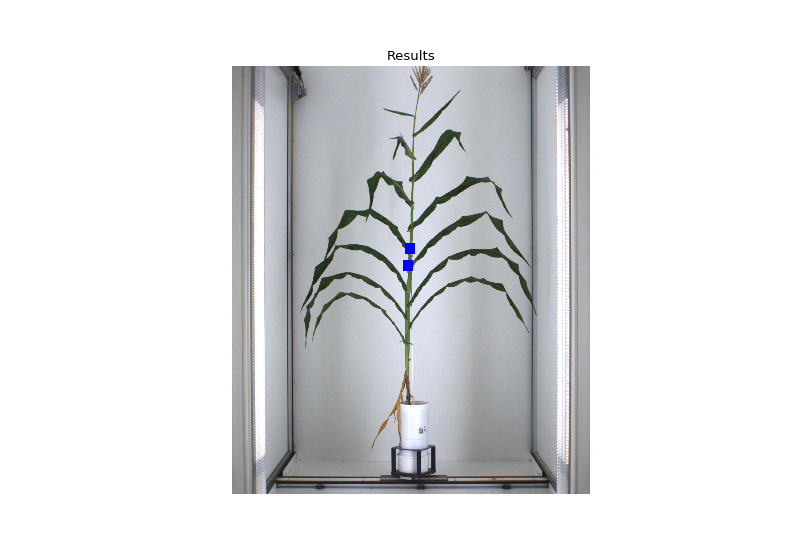

In [8]:
values = np.empty([0, 2], 'int')
im = np.empty([0], 'int')
for i in range(len(kept_positions)):
    for j in range(kept_positions[i, 2]):
        values = np.append(values, [kept_positions[i, 0:2]], axis=0)
        im = np.append(im, useful_kept_images[i])
mean_pos, finales_positions, final_kept_images = et_lib.robust_mean(values, im)
finales_positions = np.append(finales_positions, np.array([final_kept_images]).T, 1)

finale_img = images["side"][finales_positions[0, 2]].copy()
if not (mean_pos == [-1, -1]).all():
    pos = finales_positions[0, 0:2]
    finale_img[pos[0] - 30:pos[0] + 31, pos[1] - 30:pos[1] + 31, :] = (0, 255, 255)
elif finales_positions.shape[0] == 2:
    for pos in finales_positions:
        finale_img[pos[0] - 30:pos[0] + 31, pos[1] - 30:pos[1] + 31, :] = (255, 0, 0)

img_show([finale_img[:,:,::-1]], ["Results"])